# Hex Game - GTM Analysis & Experiments

This notebook performs a comprehensive analysis of the Graph Tsetlin Machine (GTM) on the Hex game.
It implements:
1.  **Robust Data Generation**: Reproducible, seeded games (saved to CSV).
2.  **End-Game Analysis**: Evaluation at Final, End-2, and End-5 moves.
3.  **Parameter Search**: Experiments for Model Capacity (Clauses) and Message Passing (Depth).
4.  **Scaling**: Flexible configuration for 3x3, 11x11, etc.

---

In [1]:
import os
import pickle
import subprocess
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import gc

# Try importing GTM
try:
    from GraphTsetlinMachine.graphs import Graphs
    from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
    HAS_GTM = True
    print("✓ GraphTsetlinMachine detected.")
except ImportError:
    print("WARNING: GraphTsetlinMachine not installed. Training will fail.")
    HAS_GTM = False

# Set Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120

✓ GraphTsetlinMachine detected.


In [2]:
# ==========================================
#            GLOBAL CONFIGURATION
# ==========================================
# CHANGE THESE VALUES TO SCALE TO 11x11

BOARD_DIM = 3          # Set to 11 for full game
N_GAMES = 10000        # Training/Test set size (Total)
SEED = 20              # Reproducible seed (User requested 20)

# GTM Hyperparameters (Default for 3x3)
# For 11x11, suggested: CLAUSES=4000+, T=3000+, DEPTH=12+
CLAUSES = 400
T = 2000
S = 5.0
DEPTH = 5
EPOCHS = 30

# Paths
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)
CSV_PATH = os.path.join(RUNS_DIR, f"hex_moves_dim{BOARD_DIM}_n{N_GAMES}.csv")

## 1. Data Generation & Processing
We use the C engine to generate games and save them to CSV. This ensures we have a permanent, reproducible dataset.

In [3]:
def generate_data():
    """Generates game data using ./scripts/run_hex.sh"""
    if os.path.exists(CSV_PATH):
        print(f"Found existing data: {CSV_PATH}")
        # You can uncomment the next line to force regeneration
        # os.remove(CSV_PATH)
        return
        
    print(f"Generating {N_GAMES} games for {BOARD_DIM}x{BOARD_DIM} (Seed {SEED})...")
    cmd = [
        "./scripts/run_hex.sh",
        "--games", str(N_GAMES),
        "--seed", str(SEED),
        "--dump-moves", CSV_PATH
    ]
    
    env = os.environ.copy()
    env["BOARD_DIM"] = str(BOARD_DIM)
    
    start = time.time()
    subprocess.run(cmd, env=env, check=True)
    print(f"Done in {time.time() - start:.2f}s")

def load_and_process_data(offset=0):
    """
    Loads CSV and reconstructs board states.
    offset: Number of moves before the end to capture (0=End, 2=End-2, etc.)
    """
    print(f"Processing data with Offset={offset}...")
    df = pd.read_csv(CSV_PATH)
    
    n_nodes = BOARD_DIM * BOARD_DIM
    x_feat = []
    o_feat = []
    labels = []
    
    # Group by game
    for game_id, group in tqdm(df.groupby("game_id"), desc="Replaying Games"):
        # Skip if game is too short
        if len(group) <= offset:
            continue
            
        # Slice moves
        moves = group.iloc[:-offset] if offset > 0 else group
        winner = group["winner"].iloc[0]
        
        p0 = np.zeros(n_nodes, dtype=np.int8)
        p1 = np.zeros(n_nodes, dtype=np.int8)
        
        for _, row in moves.iterrows():
            r, c, p = int(row['row']), int(row['col']), int(row['player'])
            idx = r * BOARD_DIM + c
            if 0 <= idx < n_nodes:
                if p == 0: p0[idx] = 1
                else: p1[idx] = 1
                    
        x_feat.append(p0)
        o_feat.append(p1)
        labels.append(winner)
        
    return np.array(x_feat), np.array(o_feat), np.array(labels)

def prepare_graphs(x, o, init_with=None):
    """Converts Feature Maps -> GTM Graphs"""
    if not HAS_GTM: return None
    
    n_samples = len(x)
    n_nodes = BOARD_DIM * BOARD_DIM
    
    graphs = Graphs(
        n_samples,
        symbols=["Empty", "Player0", "Player1"],
        hypervector_size=1024,
        hypervector_bits=2,
        init_with=init_with
    )
    
    # Hex Edges
    offsets = [(0, 1), (0, -1), (-1, 1), (1, -1), (-1, 0), (1, 0)]
    adjacency = {}
    for r in range(BOARD_DIM):
        for c in range(BOARD_DIM):
            u = r * BOARD_DIM + c
            adjacency[u] = []
            for dr, dc in offsets:
                nr, nc = r + dr, c + dc
                if 0 <= nr < BOARD_DIM and 0 <= nc < BOARD_DIM:
                    adjacency[u].append(nr * BOARD_DIM + nc)
    
    # Node Config
    for i in range(n_samples):
        graphs.set_number_of_graph_nodes(i, n_nodes)
    graphs.prepare_node_configuration()
    
    # Edge Config
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node(i, u, len(adjacency[u]))
    graphs.prepare_edge_configuration()
    
    # Add Edges
    for i in range(n_samples):
        for u in range(n_nodes):
            for v in adjacency[u]:
                graphs.add_graph_node_edge(i, u, v, 0)
                
    # Add Properties
    for i in range(n_samples):
        for u in range(n_nodes):
            if x[i][u]: graphs.add_graph_node_property(i, u, "Player0")
            elif o[i][u]: graphs.add_graph_node_property(i, u, "Player1")
            else: graphs.add_graph_node_property(i, u, "Empty")
                
    graphs.encode()
    return graphs

### Generate Data Now

In [4]:
generate_data()
print("Data Ready!")

Found existing data: runs/hex_moves_dim3_n10000.csv
Data Ready!


## 2. Main Experiment: End, End-2, End-5 Analysis
We train and test the model on three different game states:
1.  **End**: The final position (Easy).
2.  **End-2**: Two moves before the end (Harder).
3.  **End-5**: Five moves before the end (Hardest).

This uses the parameters configured at the top.

In [5]:
offsets = [0, 2, 5]
results_main = []

if HAS_GTM:
    for off in offsets:
        print(f"\n{'='*40}\nRunning OFFSET = {off}\n{'='*40}")
        
        # 1. Load
        X_raw, O_raw, Y = load_and_process_data(offset=off)
        
        # 2. Split
        # Simple 50/50 split
        split = len(Y) // 2
        X_train = (X_raw[:split], O_raw[:split])
        Y_train = Y[:split]
        X_test = (X_raw[split:], O_raw[split:])
        Y_test = Y[split:]
        
        print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")
        
        # 3. Graphs
        print("Building Graphs...")
        g_train = prepare_graphs(X_train[0], X_train[1])
        g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
        
        # 4. Train
        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,
            T=T,
            s=S,
            depth=DEPTH,
            message_size=512,
            message_bits=2,
            max_included_literals=32,
            grid=(16*13, 1, 1),
            block=(128, 1, 1)
        )
        
        history = []
        for ep in tqdm(range(EPOCHS), desc="Epochs"):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)
            # Track train acc
            p_train = tm.predict(g_train)
            acc = accuracy_score(Y_train, p_train)
            history.append(acc * 100)
            
        # 5. Test
        preds = tm.predict(g_test)
        final_acc = accuracy_score(Y_test, preds)
        cm = confusion_matrix(Y_test, preds)

        # Save Model
        models_dir = 'models'
        os.makedirs(models_dir, exist_ok=True)
        model_path = os.path.join(models_dir, f'hex_gtm_{BOARD_DIM}x{BOARD_DIM}_offset{off}.pkl')
        with open(model_path, 'wb') as f:
            pickle.dump(tm, f)
        print(f'Saved model to {model_path}')
        
        # Metrics
        p0 = precision_score(Y_test, preds, pos_label=0, zero_division=0)
        p1 = precision_score(Y_test, preds, pos_label=1, zero_division=0)
        
        print(f"Final Accuracy (Offset {off}): {final_acc*100:.2f}%")
        
        results_main.append({
            "offset": off,
            "acc": final_acc * 100,
            "history": history,
            "cm": cm,
            "preds": preds,
            "y_test": Y_test
        })


Running OFFSET = 0
Processing data with Offset=0...


Replaying Games: 100%|██████████| 10000/10000 [00:02<00:00, 3677.65it/s]


Train: 5000, Test: 5000
Building Graphs...
Initialization of sparse structure.


Epochs: 100%|██████████| 30/30 [04:26<00:00,  8.88s/it]


Final Accuracy (Offset 0): 83.14%

Running OFFSET = 2
Processing data with Offset=2...


Replaying Games: 100%|██████████| 10000/10000 [00:02<00:00, 4533.95it/s]


Train: 5000, Test: 5000
Building Graphs...
Initialization of sparse structure.


Epochs: 100%|██████████| 30/30 [04:49<00:00,  9.64s/it]


Final Accuracy (Offset 2): 69.54%

Running OFFSET = 5
Processing data with Offset=5...


Replaying Games: 100%|██████████| 10000/10000 [00:01<00:00, 6571.73it/s]


Train: 4509, Test: 4509
Building Graphs...
Initialization of sparse structure.


Epochs: 100%|██████████| 30/30 [03:53<00:00,  7.78s/it]


Final Accuracy (Offset 5): 85.34%


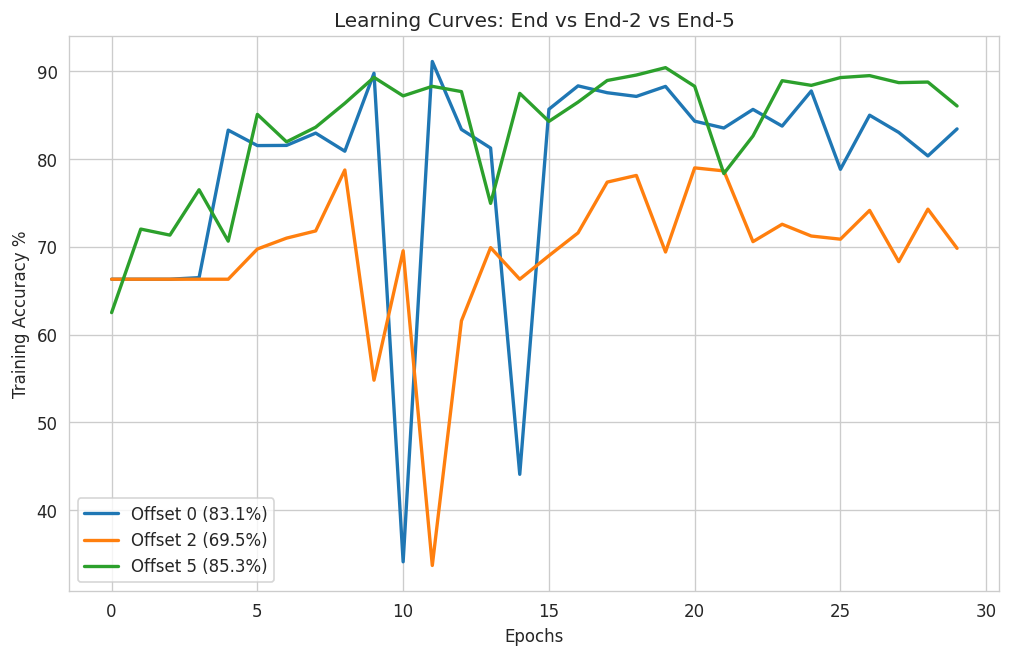

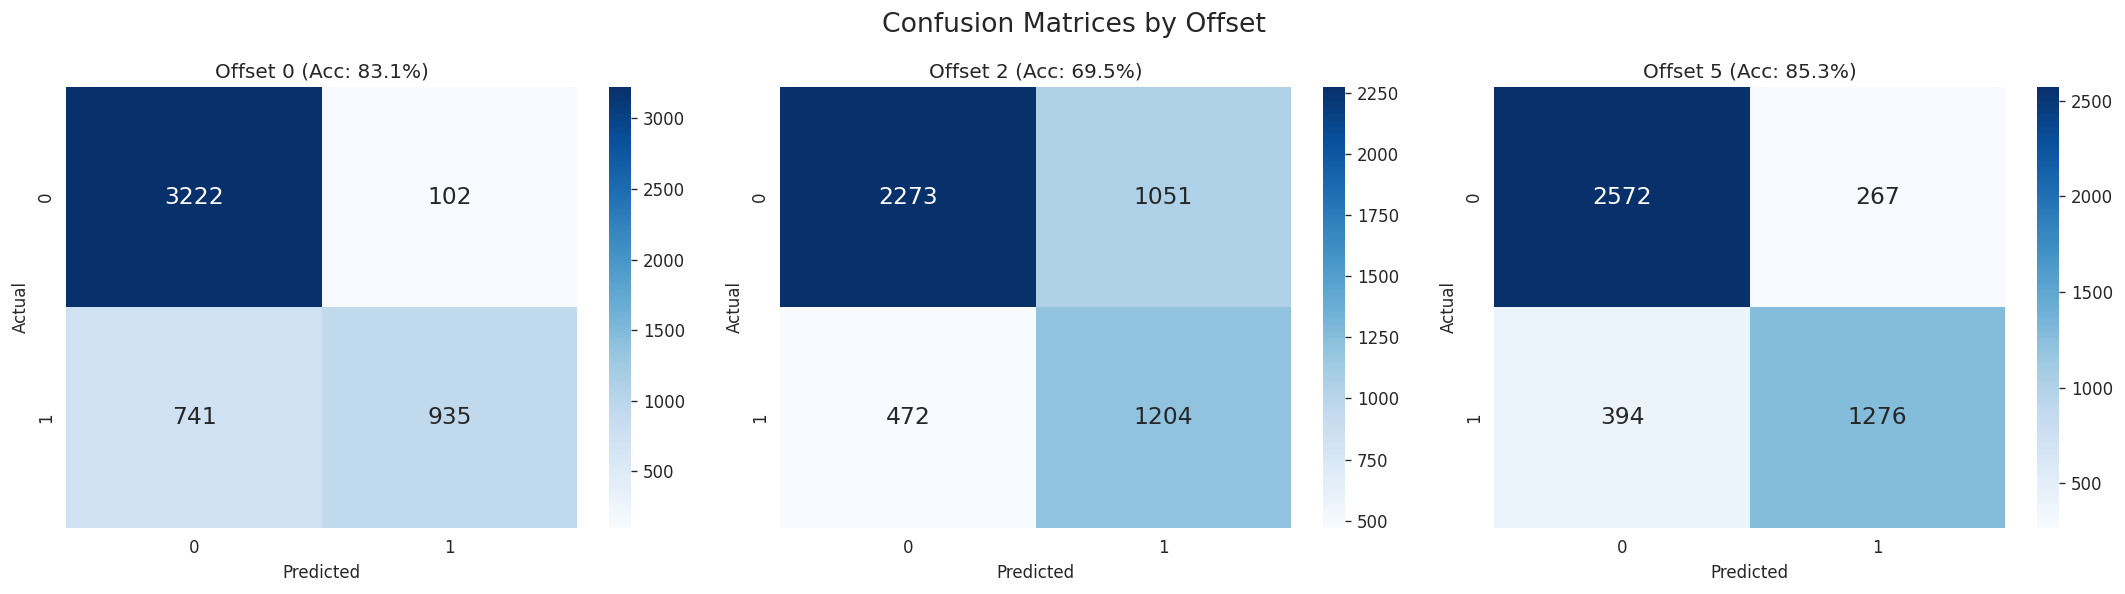

In [6]:
# Visualizing Main Experiment
if results_main:
    # Learning Curves
    plt.figure(figsize=(10, 6))
    for res in results_main:
        plt.plot(res['history'], label=f"Offset {res['offset']} ({res['acc']:.1f}%)", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy %")
    plt.title("Learning Curves: End vs End-2 vs End-5")
    plt.legend()
    plt.show()
    
    # Confusion Matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, res in enumerate(results_main):
        sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={'size': 14})
        axes[i].set_title(f"Offset {res['offset']} (Acc: {res['acc']:.1f}%)")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    plt.suptitle("Confusion Matrices by Offset", fontsize=16)
    plt.tight_layout()
    plt.show()

## 3. Parameter Search (Capacity & Depth)
Use these experiments to find the best configuration for scaling to 11x11.
This runs on the **Final** board state (Offset 0) by default to save time.

In [7]:
# === CAPACITY EXPERIMENT ===
EXP_CLAUSES = [100, 400, 1600] # Add more if needed
results_cap = []

if HAS_GTM:
    # Use dataset from Main Exp (Offset 0)
    X_raw, O_raw, Y = load_and_process_data(offset=0)
    split = len(Y)//2
    X_train, Y_train = (X_raw[:split], O_raw[:split]), Y[:split]
    X_test, Y_test = (X_raw[split:], O_raw[split:]), Y[split:]
    
    g_train = prepare_graphs(X_train[0], X_train[1])
    g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
    
    for c in EXP_CLAUSES:
        print(f"Testing Capacity: {c} Clauses...")
        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=c,
            T=T, s=S, depth=DEPTH,
            message_size=512, message_bits=2,
            grid=(16*13, 1, 1), block=(128, 1, 1)
        )
        
        # Fast training (15 epochs just for trend)
        tm.fit(g_train, Y_train, epochs=20, incremental=False)
        
        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        
        # Per class
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0])
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1])
        
        results_cap.append({
            "Clauses": c,
            "Acc": acc*100,
            "Acc0": acc0*100, 
            "Acc1": acc1*100,
            "Gap": abs(acc0-acc1)*100
        })

Processing data with Offset=0...


Replaying Games: 100%|██████████| 10000/10000 [00:02<00:00, 3928.41it/s]


Testing Capacity: 100 Clauses...
Initialization of sparse structure.


/home/coder/Tsetlin-Machine-Gun-1/.venv/lib/python3.12/site-packages/GraphTsetlinMachine/tm.py:469: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  mod_update = SourceModule(parameters + kernels.code_header + kernels.code_update, no_extern_c=True)


Testing Capacity: 400 Clauses...
Initialization of sparse structure.


/home/coder/Tsetlin-Machine-Gun-1/.venv/lib/python3.12/site-packages/GraphTsetlinMachine/tm.py:469: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  mod_update = SourceModule(parameters + kernels.code_header + kernels.code_update, no_extern_c=True)


Testing Capacity: 1600 Clauses...
Initialization of sparse structure.


/home/coder/Tsetlin-Machine-Gun-1/.venv/lib/python3.12/site-packages/GraphTsetlinMachine/tm.py:469: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  mod_update = SourceModule(parameters + kernels.code_header + kernels.code_update, no_extern_c=True)


In [8]:
# === DEPTH EXPERIMENT ===
EXP_DEPTHS = [1, 3, 5, 8]
results_depth = []

if HAS_GTM:
    for d in EXP_DEPTHS:
        print(f"Testing Depth: {d}...")
        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,
            T=T, s=S, depth=d,
            message_size=512, message_bits=2,
            grid=(16*13, 1, 1), block=(128, 1, 1)
        )
        
        tm.fit(g_train, Y_train, epochs=20, incremental=False)
        
        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0])
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1])
        
        results_depth.append({
            "Depth": d,
            "Acc": acc*100,
            "Acc0": acc0*100, 
            "Acc1": acc1*100,
            "Gap": abs(acc0-acc1)*100
        })

Testing Depth: 1...
Initialization of sparse structure.
Testing Depth: 3...
Initialization of sparse structure.
Testing Depth: 5...
Initialization of sparse structure.
Testing Depth: 8...
Initialization of sparse structure.


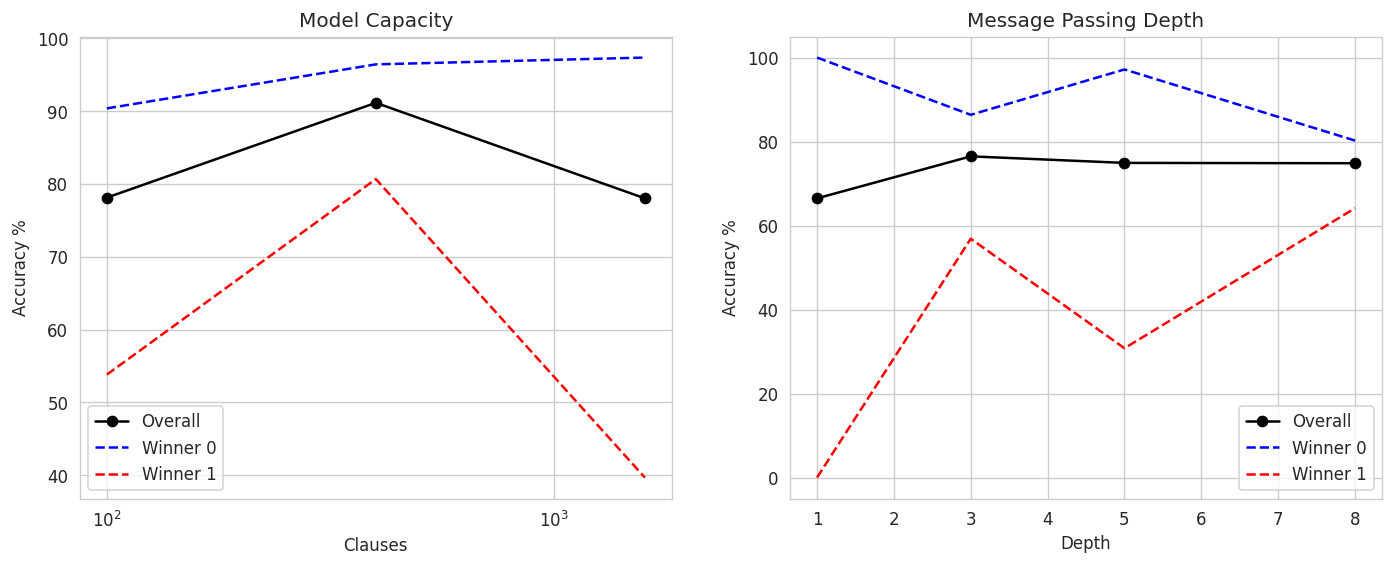

/tmp/ipykernel_28161/4085873458.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_c, x="Clauses", y="Gap", ax=ax3, palette="Reds")
/tmp/ipykernel_28161/4085873458.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_d, x="Depth", y="Gap", ax=ax4, palette="Blues")


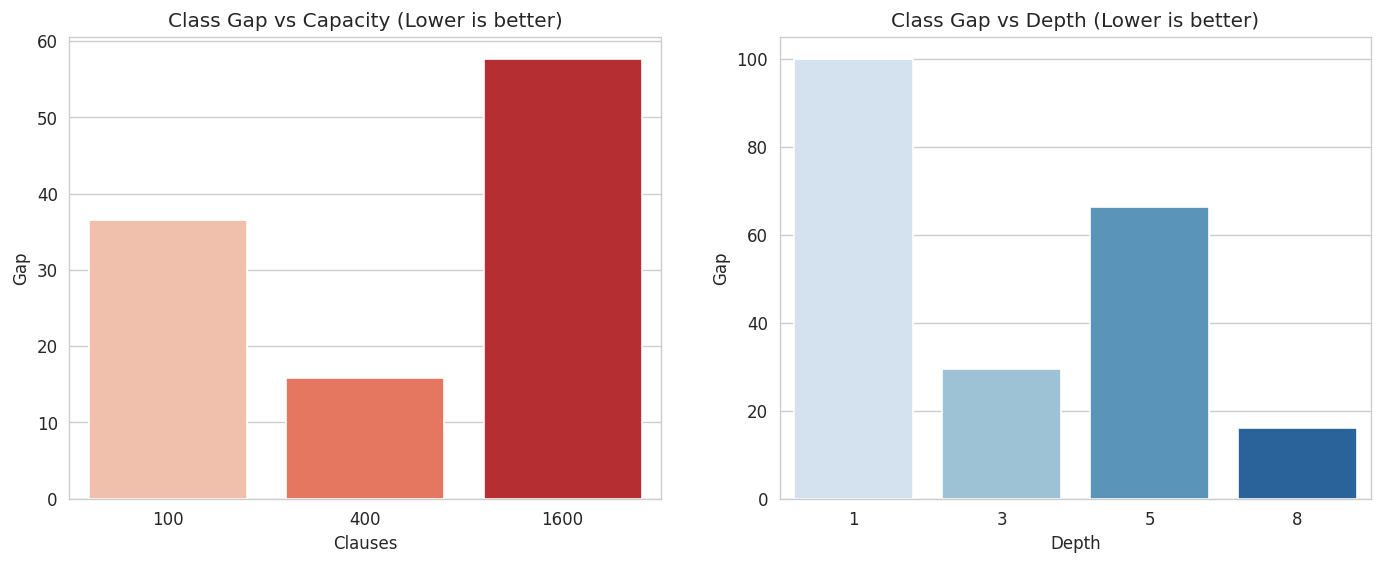

In [9]:
# === COMPARISON PLOTS (Friend's Style) ===
if results_cap and results_depth:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Capacity
    res_c = pd.DataFrame(results_cap)
    ax1.plot(res_c["Clauses"], res_c["Acc"], 'o-', label="Overall", color="black")
    ax1.plot(res_c["Clauses"], res_c["Acc0"], '--', label="Winner 0", color="blue")
    ax1.plot(res_c["Clauses"], res_c["Acc1"], '--', label="Winner 1", color="red")
    ax1.set_xscale('log')
    ax1.set_xlabel("Clauses")
    ax1.set_ylabel("Accuracy %")
    ax1.set_title("Model Capacity")
    ax1.legend()
    
    # Depth
    res_d = pd.DataFrame(results_depth)
    ax2.plot(res_d["Depth"], res_d["Acc"], 'o-', label="Overall", color="black")
    ax2.plot(res_d["Depth"], res_d["Acc0"], '--', label="Winner 0", color="blue")
    ax2.plot(res_d["Depth"], res_d["Acc1"], '--', label="Winner 1", color="red")
    ax2.set_xlabel("Depth")
    ax2.set_ylabel("Accuracy %")
    ax2.set_title("Message Passing Depth")
    ax2.legend()
    
    plt.show()
    
    # Gap Plot
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(data=res_c, x="Clauses", y="Gap", ax=ax3, palette="Reds")
    ax3.set_title("Class Gap vs Capacity (Lower is better)")
    sns.barplot(data=res_d, x="Depth", y="Gap", ax=ax4, palette="Blues")
    ax4.set_title("Class Gap vs Depth (Lower is better)")
    plt.show()